# Homework 3 - Places of the world

In [72]:
from fun import *

%matplotlib inline
pd.set_option("display.precision", 10)

In [74]:
# Create an instance of the logger
logger = logging.getLogger()

# Set up
log_format = logging.Formatter('%(asctime)-15s %(levelname)-2s %(message)s')
file_handler = logging.FileHandler(f'logs/logs_{datetime.today().strftime("%d-%m-%Y")}.log')
file_handler.setFormatter(log_format)

# Add handler
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

# 1. Data collection

### 1.1 Get the list of places

In [4]:
site = 'https://www.atlasobscura.com'

In [13]:
# Get list of all places
get_places(site=site, pages=list(range(1, 401)), filename='places_ref.txt')

100%|██████████| 400/400 [11:02<00:00,  1.66s/it] 


### 1.2. Crawl places

In [14]:
# Make a list of (url, page) tuples
places = [(site + line.rstrip().split(' ')[1], line.rstrip().split(' ')[0]) for line in open('places_ref.txt')]

In [30]:
# Download each page and save it into its page folder
for url, page in tqdm(places):
    download_place(url, page)

100%|██████████| 7200/7200 [7:37:17<00:00,  3.81s/it]   


### 1.3 Parse downloaded pages

In [55]:
# For every page parse each html file
for directory in tqdm(os.listdir('./data/html')):
    for file in os.listdir(f'./data//html/{directory}'):
        try:
            parse_page(file_path=f'data/html/{directory}/{file}', export_tsv=True)
        except:
            logging.exception(f'error at {directory} for {file}')

100%|██████████| 400/400 [15:10<00:00,  2.28s/it]


In [61]:
# Create a merged copy of all the data to work with in the next steps
df_places = pd.DataFrame()

for table in tqdm(os.listdir('./data/tables')):
    tsv = pd.read_csv('./data/tables/' + table, delimiter='\t')
    df_places = pd.concat([df_places, tsv]).reset_index(drop=True)

df_places.to_csv('data/merged_places.tsv', sep='\t')

100%|██████████| 7200/7200 [00:26<00:00, 269.32it/s]


### 2. Search Engine

In [ ]:
pre_process_tsv()
df_places = pd.read_csv('data/processed_merged_places.tsv', delimiter='\t', index_col=0)

### 2.1. Conjunctive query

In [78]:
# Build a vocabulary that match each word with an id

word_list = list(Counter(reduce(lambda x, y: x + y, df_places['placeDesc'].apply(lambda x: eval(x)))))

vocabulary = {}
word_id = 0

for word in word_list:
    vocabulary[word] = word_id
    word_id += 1

In [259]:
# Build the first inverted index

inverted_index = {}

for word, word_id in tqdm(vocabulary.items()):
    inverted_index[word_id] = list(df_places[df_places['placeDesc'].apply(lambda row: word in row)].index)

100%|██████████| 39551/39551 [05:20<00:00, 123.39it/s]


In [260]:
# Pickle inverted index
with open('inverted_index.pickle', 'wb') as handle:
    pickle.dump(inverted_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [79]:
# Load inverted index
with open('inverted_index.pickle', 'rb') as handle:
    inverted_index = pickle.load(handle)

In [80]:
def simple_conjunctive_query(query):
    '''
    Given a text input execute a conjunctive query that returns all the places that match every word of the query
    :param query: text input
    :return: dataframe with columns: placeName, placeDesc, placeURL
    '''


    # Get documents indexes that match the query input
    results = [set(inverted_index[item]) for item in [vocabulary[word] for word in pre_process_text(query)]]
    indexes = set.intersection(*map(set, results))

    # Get places urls
    urls = df_places.iloc[list(indexes)]['placeURL']

    output = pd.DataFrame()

    # Get places
    for url in urls:
        try:
            slug = url.split('places/')[1]

            place = pd.read_csv(f'data/tables/{slug}.tsv', delimiter='\t', index_col=0)

            output = pd.concat([output, place])
        except:
            pass

    return output.reset_index()[['placeName', 'placeDesc', 'placeURL']]

simple_conjunctive_query("american museum")

,placeName,placeDesc,placeURL
0,Museum of the Eye,How do you see the world? Find out at the Muse...,https://www.atlasobscura.com/places/museum-oph...
1,Museum of Quackery and Medical Frauds,"While technically this museum closed in 2002, ...",https://www.atlasobscura.com/places/museum-qua...
2,"Harriet Beecher Stowe, Slavery to Freedom Museum",This early brick Georgian townhouse sits incon...,https://www.atlasobscura.com/places/harriet-be...
3,Peden's Cave,Found at the top of a red stone cliff overlook...,https://www.atlasobscura.com/places/pedens-cave
4,Museum of the Weird,The dime or dime store museum is by all accoun...,https://www.atlasobscura.com/places/museum-weird
...,...,...,...
257,Rugby Colony,"Rugby, Tennessee, was established in 1880 as a...",https://www.atlasobscura.com/places/rugby-colony
258,Museum of Un-Natural History,"Throughout the ’70s and ’80s, Gerald Matthews ...",https://www.atlasobscura.com/places/museum-of-...
259,Treasures of the Steamboat Arabia,When the mighty Steamboat Arabia sank near Kan...,https://www.atlasobscura.com/places/treasures-...
260,Museum of Whimsy,Spread across two floors of a regal old 1920s ...,https://www.atlasobscura.com/places/museum-of-...


## 2.2 Conjunctive query & Ranking score

In [263]:
# Building a new inverted index with tfidf scores

tf_idf = {}

for place_index, description in tqdm(enumerate(df_places['placeDesc'])):

    description = eval(description)
    counter = Counter(description)

    for token in np.unique(description):
        # Calculate the Term Frequency as the number of relative frequency of a token in a single document
        tf = counter[token] / len(np.unique(description))

        # Calculate the Document Frequency as the number of occurrences in all documents
        df = len(inverted_index[vocabulary[token]])

        # Calculate the Inverse Document Frequency as the log(N places / (df + 1))
        idf = np.log(len(df_places['placeDesc']) / (df+1))

        # Calculate the final tfidf score
        if vocabulary[token] not in tf_idf.keys():
            tf_idf[vocabulary[token]] = []
        tf_idf[vocabulary[token]].append((place_index, tf * idf))

7291it [00:51, 141.89it/s]


In [264]:
# Pickle tf_idf
with open('tf_idf.pickle', 'wb') as handle:
    pickle.dump(tf_idf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
# Load tf_idf
with open('tf_idf.pickle', 'rb') as handle:
    tf_idf = pickle.load(handle)

In [144]:
def ranked_conjunctive_query(query, k=5):
    '''
    Given a text input execute a conjunctive query returning the top-K places ranked by cosine similarity
    :param query: text input
    :param k: number of places to extract
    :return: dataframe with columns: placeName, placeDesc, placeURL
    '''

    # Process query input
    query_tokens = pre_process_text(query)

    # Calculate tf-idf score for query tokens
    counter = Counter(query_tokens)
    query_weights = {}
    query_token_ids = [vocabulary[query_token] for query_token in query_tokens]

    for token in np.unique(query_tokens):
        tf = counter[token] / len(query_tokens)
        df = len(inverted_index[vocabulary[token]])
        idf = np.log(len(df_places) / (df + 1))

        query_weights[vocabulary[token]] = tf * idf

    # Query vectorization
    Q = np.zeros((len(query_tokens), 1))

    for idx, token_id in enumerate(query_token_ids):
        Q[idx][0] = query_weights[token_id]

    # Document vectorization
    D = np.zeros((len(query_tokens), len(df_places)))

    for idx, token_id in enumerate(query_token_ids):
        for doc_id, score in tf_idf[token_id]:
            D[idx][int(doc_id)] = score

    # Calculate cosine similarity
    cosine_similarity_scores =  np.dot(D.transpose(), Q) / (np.linalg.norm(D) * np.linalg.norm(Q))

    # Get the K-top places
    indexes = np.argsort(cosine_similarity_scores.flatten(), kind='heapsort', )[::-1][:k]

    # Get places urls
    urls = df_places.iloc[indexes.flatten()]['placeURL']

    output = pd.DataFrame()

    # Get places
    for url in urls:
        try:
            slug = url.split('places/')[1]

            place = pd.read_csv(f'data/tables/{slug}.tsv', delimiter='\t', index_col=0)

            output = pd.concat([output, place])
        except:
            pass

    # Add cosine similarity to places infos
    output['similarity'] = cosine_similarity_scores[indexes]

    return output.reset_index()[['placeName', 'placeDesc', 'placeURL', 'similarity']]

ranked_conjunctive_query("Gustave Eiffel")

,placeName,placeDesc,placeURL,similarity
0,Gustave Eiffel's Secret Apartment,When the Eiffel Tower opened in 1889 to much w...,https://www.atlasobscura.com/places/gustave-ei...,0.5138806852
1,Texas Eiffel Tower,Cities named Paris outside of France all seem ...,https://www.atlasobscura.com/places/texas-eiff...,0.4090382343
2,The Eiffel Tower of New Orleans,"Up until 1981, the Restaurant de La Tour Eiffe...",https://www.atlasobscura.com/places/the-eiffel...,0.2752200548
3,The Atomium,In 1958 the Atomium was built for the Brussels...,https://www.atlasobscura.com/places/the-atomiu...,0.1771363119
4,Temple de la Sybille (The Temple of Sybille),The Temple de la Sybille is a Roman-style monu...,https://www.atlasobscura.com/places/la-temple-...,0.1461024706


# 3. Define a new score!

# 4. Visualizing the most relevant places

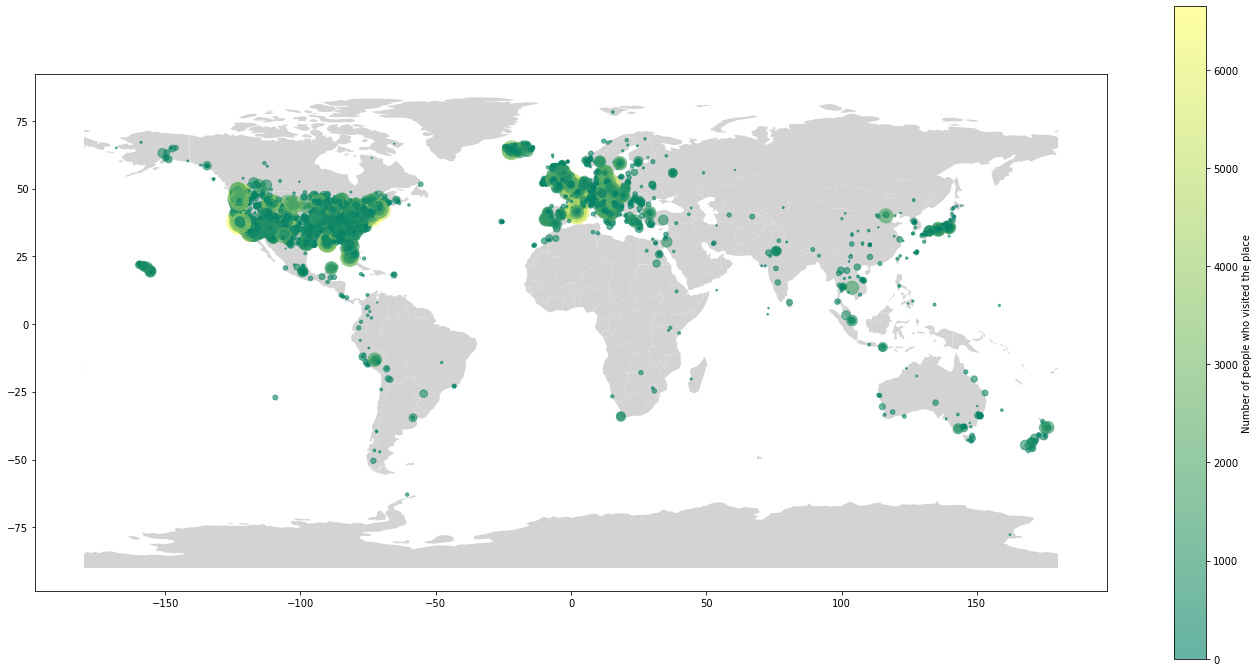

In [208]:
# Set columns
df_places['placeAlt'] = pd.to_numeric(df_places['placeAlt'], errors='coerce')
df_places['placeLong'] = pd.to_numeric(df_places['placeLong'], errors='coerce')
df_places['numPeopleVisited'] = pd.to_numeric(df_places['numPeopleVisited'], errors='coerce')

# Drop null values
df_places.dropna()
df_places = df_places.reset_index(drop=True)

# Get world map
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(24, 12))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting coordinates and the number of visits with a color map
x = df_places['placeLong']
y = df_places['placeAlt']
z = df_places['numPeopleVisited']

plt.scatter(x, y, s=z/10, c=z, alpha=0.6, cmap='summer')
plt.colorbar(label='Number of people who visited the place')

# 7. Theoretical question

1. Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).

In [5]:
# First Algorithm: Merge Sort

def merge_sort(list):
    '''
    Sort list with merge sort algorithm
    :param list:
    :return:
    '''

    if len(list) > 1:

        # Find the center of the list
        middle = len(list) // 2

        # Divide the list
        left_list = list[:middle]
        right_list = list[middle:]

        # Sort the first half
        merge_sort(left_list)

        # Sort the second half
        merge_sort(right_list)

        # Initialize indexes
        i = j = k = 0

        # Copy data to temp lists left_list and right_list
        while i < len(left_list) and j < len(right_list):
            if left_list[i]['avg'] > right_list[j]['avg']:
                list[k] = left_list[i]
                i += 1
            elif left_list[i]['avg'] < right_list[j]['avg']:
                list[k] = right_list[j]
                j += 1
            # If the average of grades are equal order by name
            else:
                if name_is_before_name(left_list[i]['name'], right_list[j]['name']):
                    list[k] = left_list[i]
                    i += 1
                else:
                    list[k] = right_list[j]
                    j += 1
            k += 1

        # Check if any element was left
        while i < len(left_list):
            list[k] = left_list[i]
            i += 1
            k += 1

        while j < len(right_list):
            list[k] = right_list[j]
            j += 1
            k += 1

In [10]:
# Second Algorithm: Quick Sort

def find_pivot(list, low, high):
    '''
    Find pivot for quick sort
    :param list:
    :param low:
    :param high:
    :return: index of the partion made
    '''

    # Select the last element of the list as pivot
    pivot = list[high]

    # Index of the minor element
    i = low - 1

    # Compare each element of the list with the pivot
    for j in range(low, high):
        # If a greater element is found swap it with the minor element
        if list[j]['avg'] > pivot['avg']:
            i = i + 1
            tmp = list[i]
            list[i] = list[j]
            list[j] = tmp

        # If the average of grades are equal order by name
        elif list[j]['avg'] == pivot['avg']:
            if name_is_before_name(list[j]['name'], pivot['name']):
                i = i + 1
                tmp = list[i]
                list[i] = list[j]
                list[j] = tmp

    # Swap the pivot element with the minor element
    tmp = list[i + 1]
    list[i + 1] =  list[high]
    list[high] = tmp

    # Return the partition index
    return i + 1

def quick_sort(list, low, high):
    '''
    Sort list with quick sort algotithm
    :param list:
    :param low:
    :param high:
    :return:
    '''

    if low < high:
        pivot = find_pivot(list, low, high)

        quick_sort(list, low, pivot - 1)
        quick_sort(list, pivot + 1, high)

In [68]:
# Third Algorithm: Insertion Sort

def insertion_sort(list):
    '''
    Sort list with insertion sort algotithm
    :param list:
    :return:
    '''

    for i in tqdm(range(1, len(list))):
        # Set the current element as key
        key = list[i]

        # Set another index to iter part of the list
        j = i - 1

        # Move elements that are lesser than the key to one position ahead of their current position
        while j >= 0 and key['avg'] >= list[j]['avg']:
            if key['avg'] > list[j]['avg']:
                    list[j+1] = list[j]
                    j -= 1

            # If the average of grades are equal order by name
            elif key['avg'] == list[j]['avg']:
                if name_is_before_name(key['name'], list[j]['name']):
                    list[j+1] = list[j]
                    j -= 1

        list[j] = key

2. What is the time complexity of each algorithm you have used?

Merge Sort: has both worst-case and best-case time complexity of O(N log(N)).

Quick Sort: has worst-case time complexity of O(N^2)) and best-case time complexity of O(N log(N)) which is the average-case.

Insertion Sort: has worst-case time complexity of O(N^2)) and best-case time complexity of O(N).

3. Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.

In [32]:
students = get_students()

start_time = time.time()
merge_sort(students)
print(f'Merge sort runtime: {(time.time() - start_time)}')

Merge sort runtime: 0.345839262008667


In [33]:
students = get_students()

start_time = time.time()
quick_sort(students, 0, len(students) - 1)
print(f'Quick sort runtime: {(time.time() - start_time)}')

Quick sort runtime: 0.31418609619140625


In [ ]:
students = get_students()

start_time = time.time()
insertion_sort(students)
print(f'Insertion sort runtime: {(time.time() - start_time)}')

4. What is the most optimal algorithm, in your opinion, and why?

It can be seen from the computation times that the quick sort is the fastest algorithm. Although the time complexity of the average case is the same as that of the merge sort, the latter has O(N) space complexity. Allocating and deallocating this space increases the execution time of the merge sort.

As for insertion sort, the algorithm is not suitable for the problem because its computation time is much higher than the other two algorithms (this is due to its O(N^2) time complexity). Although I knew that this algorithm was suitable for sorting small lists, I chose it as the third to show how time complexity can affect us and why we should be more careful to choose the right tool when working with large amounts of data.

In conclusion, we can say that quick sort is the most optimal algorithm for the given problem.

5. Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.